# Libraries

In [1]:
import geopandas as gpd
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4_3D,ParticleFile,ErrorCode,AdvectionRK4, Variable,VectorField,Field, FieldSamplingError
from parcels import plotTrajectoriesFile
import pandas as pd
from scipy import interpolate
from glob import glob
import numpy as np
from datetime import date,timedelta
import datetime
import xarray as xr
import pytz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
import imageio
import matplotlib.font_manager as fm
import math
pd.set_option("display.precision", 8)
from netCDF4 import Dataset
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
import warnings
from datetime import timedelta as delta
import pdb
#warnings.filterwarnings('ignore')

# Function just for plotting

In [2]:
def subset_hydromodel(latitudes, longitudes, lat_prtcl, lon_prtcl, variable):
    ## Subset of the hydromodel
    latmin = lat_prtcl - 0.07
    latmax = lat_prtcl + 0.07
    lonmin = lon_prtcl - 0.05
    lonmax = lon_prtcl + 0.05
    # getting index for lat and lon
    diff_max = np.abs(latmax - latitudes) + np.abs(lonmax - longitudes)
    diff_min = np.abs(latmin - latitudes) + np.abs(lonmin - longitudes)
    latlon_max = np.where(diff_max == diff_max.min())
    latlon_min = np.where(diff_min == diff_min.min())
    latmin = latlon_min[0].item(); lonmin = latlon_min[1].item()
    latmax = latlon_max[0].item(); lonmax = latlon_max[1].item()
    ## lat and lons for the selected area )
    subset_lons  = np.asarray(longitudes[latmin : latmax, lonmin : lonmax])
    subset_lats  = np.asarray(latitudes[latmin : latmax, lonmin : lonmax])
    subset_var   = np.asarray(variable[latmin : latmax, lonmin : lonmax])
    return(subset_lats, subset_lons, subset_var)

def DeleteParticle(particle, fieldset, time):
    particle.delete()

# OCEANPARCELS run for GBR1
### MRE

INFO: Compiled JITParticleAdvectionRK4 ==> /tmp/parcels-546549/2a7964ec261d6d82fb9cdb68511fcc5a_0.so
/home/por07g/miniconda3/envs/salish_sea_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/por07g/miniconda3/envs/salish_sea_env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


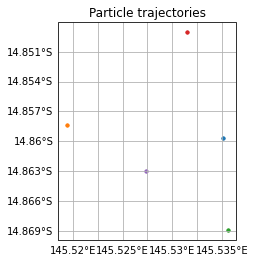

In [3]:
data_path = '/home/por07g/Documents/Projects/GBR_modeling/GBR_oceanparcels/GBR_main/Data/'
files = sorted(glob(data_path+'gbr1_simple_*.nc'))
mesh_mask = data_path + 'coordinates.nc'
filenames = {'U': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': files[0], 'data': files},
             'V': {'lon': mesh_mask, 'lat': mesh_mask, 'depth': files[0], 'data': files}}
variables = {'U': 'u',
             'V': 'v'}
dimensions = {'U': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'zc', 'time': 'time'},
              'V': {'lon': 'longitude', 'lat': 'latitude', 'depth': 'zc', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, allow_time_extrapolation = True)

lon_part = [145.53506554786637, 145.51936068493657, 145.5356358863923, 145.53145637880326, 145.52736346809914]
lat_part = [-14.859701485520151, -14.85834488238424, -14.86892276514238, -14.849033419881252, -14.862993266736664]
## Depth tried -5.35; -2; -1
depth_part = [0]*len(lat_part)
pset = ParticleSet.from_list(fieldset, pclass=JITParticle,
                                 lon = lon_part,
                                 lat = lat_part,
                                 depth = depth_part)    
# setting the Kernel
kernels = pset.Kernel(AdvectionRK4) 
output_file = "/home/por07g/Documents/Projects/GBR_modeling/GBR_oceanparcels/GBR_main/MRE"
pfile = pset.ParticleFile(output_file, outputdt = delta(hours=1))
pset.execute(kernels, runtime = delta(days = 1), dt = delta(hours = 1),
             output_file = pfile, recovery = {ErrorCode.ErrorOutOfBounds: DeleteParticle})

pfile.export()  # export the trajectory data to a netcdf file
plotTrajectoriesFile(output_file+".nc");



# Check if the particles are been seeded on water

In [4]:
# I tried for time = 0, 2, 3600, 7200 getting the same result
fieldset.UV[7200, 0, lat_part[0], lon_part[0]]

Correct cell not found after 1000000 iterations


FieldOutOfBoundError: U sampled out-of-bound, at (145.535066, -14.859701, 0.000000)

In [5]:
Hydro_file = '/home/por07g/Documents/Projects/GBR_modeling/GBR_oceanparcels/GBR_main/Data/gbr1_simple_2014-12-02.nc'
## Hydro_file = '/home/por07g/Documents/Projects/GBR_modeling/GBR_oceanparcels/GBR_main/Data/gbr1_simple_2014-12-02.nc'
hydro_nc = xr.open_dataset(Hydro_file)
latitudes = hydro_nc['latitude']
longitudes = hydro_nc['longitude']
u = hydro_nc['u'][3, 42]
v = hydro_nc['v'][3, 42]
z = hydro_nc['botz']
zc=hydro_nc['zc']

# plotting Polygons + Hydro + particles

In [6]:
# Shapefile
shapefile_name='/home/por07g/Documents/Projects/GBR_modeling/GBR_oceanparcels/GBR_main/Shape_files/gbr1_coral_1m_merged.shp'
# polygons from [0-3805]
polygon_selected=1072 #986
## reading the shape file
data_shape = gpd.read_file(shapefile_name)
value_index = list(data_shape.loc[data_shape['FID'] == polygon_selected].index)
value_index = int("".join(map(str, value_index)))
polygon = data_shape['geometry'][value_index]
base_polygon = gpd.GeoSeries([polygon])
bounds = polygon.bounds
def coord_lister(geom):
    coords = np.array(geom.exterior.coords)
    return (coords)
polygon_selected = base_polygon.geometry.apply(coord_lister).values[0]

# Get some parameters for the Stereographic Projection
lon_0 = np.nanmean((bounds[0],bounds[2]))
lat_0 = np.nanmean((bounds[1],bounds[3]))
## Subset the map
[subset_lats_U, subset_lons_U, subset_var_U] = subset_hydromodel(latitudes, longitudes, lat_0, lon_0, u)
[subset_lats_V, subset_lons_V, subset_var_V] = subset_hydromodel(latitudes, longitudes, lat_0, lon_0, v)
[subset_lats_Z, subset_lons_Z, subset_var_Z] = subset_hydromodel(latitudes, longitudes, lat_0, lon_0, z)


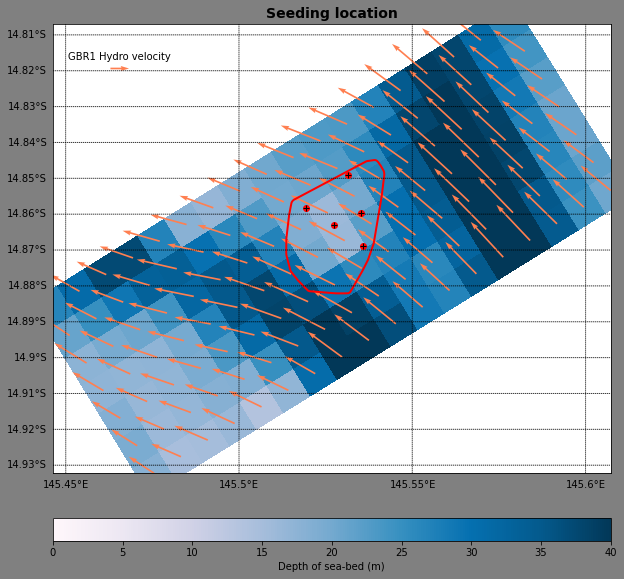

In [9]:
fig=plt.figure(figsize=(10,12),facecolor='grey')
m = Basemap(llcrnrlon = subset_lons_V.min() ,llcrnrlat= subset_lats_V.min() ,urcrnrlon = subset_lons_V.max(), urcrnrlat = subset_lats_V.max(), \
            resolution='h',projection='lcc',lon_0 = lon_0, lat_0 = lat_0)
m.drawparallels(np.arange(-17., -13., .01), labels=[1,0,0,0], fontsize=10)
m.drawmeridians(np.arange(145., 147, .05), labels=[0,0,0,1], fontsize=10)
# Add Coastlines, States, and Country Boundaries
m.drawcoastlines()
#m.shadedrelief()
m.drawcountries()
m.fillcontinents(color='#cc9955', zorder = 0)
xp, yp=np.meshgrid(lon_part, lat_part)
xp, yp=m(xp,yp)
# Grid the co-ordinates
#X,Y = np.meshgrid(prt_lon_Nemo, prt_lat_Nemo)
lons,lats = m(subset_lons_U,subset_lats_U) # convert the co-ordinates to fit on the map
cs = m.pcolor(lons, lats, subset_var_Z, cmap='PuBu',vmin=0, vmax=40)
q1 = m.quiver(lons, lats, subset_var_U, subset_var_V, color='coral', scale=3,width=0.003)

xi_poly, yi_poly = m(polygon_selected[:,0], polygon_selected[:,1])
poly = Polygon(list(zip(xi_poly, yi_poly)) ,facecolor='none',edgecolor='red',linewidth=2)
plt.gca().add_patch(poly)
cbar = m.colorbar(cs, location='bottom', pad="10%")
cbar.set_label('Depth of sea-bed (m)')
m.plot(xp[0,:],yp[:,0],marker='o',color='red',linestyle = 'None')
m.plot(xp[0,:],yp[:,0],marker='+',color='black',linestyle = 'None')

plt.title('Seeding location', fontsize=14, fontweight = 'bold')
plt.quiverkey(q1, 0.12, 0.9, 0.1, 'GBR1 Hydro velocity', coordinates='axes')
plt.savefig('Figures/Seeding_location.png',edgecolor='grey')
plt.show()

In [8]:
145.52250688691095, -14.857701180429903

(145.52250688691095, -14.857701180429903)